# Zadania

In [1]:
# Two-class MNIST 
import os
os.environ['KERAS_BACKEND'] = 'theano'
from keras.datasets import mnist
import numpy as np
import random

d1 = 5
d2 = 6

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

X_train = (mnist_x_train.astype('float32') / 255.).reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
y_train = mnist_y_train
X_test = (mnist_x_test.astype('float32') / 255.).reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
y_test = mnist_y_test

X_train = X_train[np.logical_or(y_train == d1, y_train == d2)]
y_train = y_train[np.logical_or(y_train == d1, y_train == d2)]
y_train[y_train==d1] = 0
y_train[y_train==d2] = 1
X_test = X_test[np.logical_or(y_test == d1, y_test == d2)]
y_test = y_test[np.logical_or(y_test == d1, y_test == d2)]
y_test[y_test==d1] = 0
y_test[y_test==d2] = 1

print X_train.shape
print X_test.shape

Using Theano backend.


(11339, 784)
(1850, 784)


## Ćwiczenie 1 [5 pkt]

Uzupełnij metody forward_pass oraz backward_pass w klasach ReLU, Sigmoid i Dense. Metoda forward_pass ma przyjmować batch inputów i zwracać batch outputów. Metoda backward_pass ma przyjmować batch inputów oraz batch pochodnych cząstkowych outputów i zwracać batch pochodnych cząstkowych inputów oraz wektor (**nie batch**) pochodnych cząstkowych wag. Jeśli wagi przechowujemy w macierzy dwuwymiarowej, to możemy najpierw policzyć pochodne cząstkowe w macierzy o takim samym kształcie, a następnie np. użyć .flat.

## Ćwiczenie 2 [4 pkt]

Uzupełnij metodę _forward_pass klasy Network. Metoda ta ma przyjmować batch inputów (X) i zwracać dwie rzeczy:
* inps - lista batchów inputów dla każdej warstwy w sieci (włącznie z X); te wartości będziemy używali w metodzie _backward_pass
* output - batch outputów z sieci (czyli $\mathbf{\hat y}$); output **nie** powinien być ostatnim elementem inps.

## Ćwiczenie 3 [5 pkt]

Uzupełnij metodę _backward_pass klasy Network. Zwróć uwagę, że pochodna funkcji kosztu po neuronach ostatniej warstwy jest już liczona w metodzie _fit_on_batch. Metoda ma zwracać listę layer_grads, której elementy to wektory pochodnych cząstkowych funkcji kosztu po kolejnych warstwach (zwrócone przez metodę Layer.backward_pass). Kolejność wektorów w tej liście ma być zgodna z kolejnością warstw w sieci.

## Ćwiczenie 4 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą i aktywacją Sigmoid na powyższych danych (dwuklasowy MNIST). Użyj MSE jako funkcji kosztu (oznacza to regresję do numeru klasy, co jest złym pomysłem, ale póki nie mamy klasy Crossentropy musi nam to wystarczyć). Użyj GD. Reportuj loss oraz accuracy.

## Ćwiczenie 5 [3 pkt]
Uzupełnić klasę Crossentropy, wzorując się na klasie MSE.

## Ćwiczenie  6 [3 pkt]
Uzupełnić klasę Momentum, wzorując się na klasie GD. Wzory można znaleźć tutaj: http://distill.pub/2017/momentum/

## Ćwiczenie 7 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą. Rozważ dwa przypadki: aktywację ReLU oraz Sigmoid. Czy jest sens używać ReLU jako ostatnią warstwę? Użyj Crossentropy jako funkcji kosztu. Użyj Momentum. Reportuj loss oraz accuracy.

## Ćwiczenie 8 [6 pkt]
Vanishing gradient.

Zadanie polega na zbadaniu zjawiska *vanishing gradient* w głębokich sieciach. Należy zmodyfikować kod warstwy Dense i dodać monitorowanie **normy euklidesowej** wektora delta_weights. Każdą warstwę Dense w trenowanej sieci należy monitorować oddzielnie. Po każdym wywołaniu metody fit_on_batch każdy z monitorów powinien zapamiętać nową normę. Po nauczeniu sieci dla każdej warstwy należy narysować wykres: poziomo - numer wywołania fit_on_batch, pionowo - norma delta_weights. Im niżej znajduje się warstwa Dense, tym silniej będzie zachodziło zjawisko *vanishing gradient*.

Naucz dwuwarstwową sieć z aktywacjami Sigmoid, reportując normy delta_weights. Powtórz to dla głębszej sieci (np. 6-10 warstw).

## Ćwiczenie 9 [4 pkt]
Przetestować kod z ćwiczenia 7. (dwuwarstwowa sieć) stosując inne inicjalizacje wag w warstwach Dense. Napisać własną inicjalizację wag, która sprawi, że sieć niczego się nie nauczy (init='stupid').


In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
class Layer():

    def forward_pass(self, input):
        # return output
        raise NotImplementedError()

    def backward_pass(self, input, output_grad):
        # return input_grad, weight_grad
        raise NotImplementedError()

    def update_weights(self, delta_weights):
        pass

    def debug_grad(self, evaluate_loss):
        return None

In [4]:
class ReLU(Layer):
    #Ćwiczenie 1 
    def forward_pass(self, input):
        return np.asmatrix(np.vectorize(lambda x: x if x >= 0 else 0)(input))
    #Ćwiczenie 1 
    def backward_pass(self, input, output_grad):
        return  np.array([ np.multiply( output_grad[i,:],  
            np.vectorize(lambda x: 1 if x >= 0 else 0)
                (input[i,:])   ).tolist()[0] for i in xrange(input.shape[0])]), None    

In [5]:
def sigmoid(gamma):
    if gamma < 0:
        return 1. - 1./(1. + math.exp(gamma))
    else:
        return 1./(1. + math.exp(-gamma))

class Sigmoid(Layer):
    #Ćwiczenie 1 
    def forward_pass(self, input):
        return np.asmatrix(np.vectorize(sigmoid)(input))
    
    #Ćwiczenie 1 
    def backward_pass(self, input, output_grad):
        input_grad = np.array([ np.multiply( output_grad[i],  
                np.vectorize(lambda x: sigmoid(x) * sigmoid(-x) )
                    (input[i,:])   ).tolist()[0]  for i in xrange(input.shape[0])])
        weight_grad = None
        return  input_grad, weight_grad

In [12]:
class Dense(Layer):

    def __init__(self, input_size, output_size, init = 'gaussian', plot=False):
        self.plot = plot
        self.monitor = []
        input_size += 1
        if init == 'zeros':
            self.weights = np.zeros((input_size, output_size))
        elif init == 'gaussian':
            np.random.seed(1)
            self.weights = np.random.normal(
                0.,
                2. / (input_size + output_size),
                (input_size, output_size)
            )
        elif init == 'aaa':
            np.random.seed(1)
            self.weights = np.random.choice([0.001, 1000.01],  (input_size, output_size)  )
        else:
            raise NotImplementedError()
        self.weights = np.asmatrix(self.weights)

    #Ćwiczenie 1 
    def forward_pass(self, input):
        input = np.append(input, np.array([[1] for i in input]), axis=1)
        return np.dot(input, self.weights)
    
    #Ćwiczenie 1 
    def backward_pass(self, input, output_grad):
        N = len(input)
        input = np.append(input, np.array([[1] for i in input]), axis=1)
        n = input.shape[1] 
        m = output_grad.shape[1]
        input_grad = np.dot(output_grad, (self.weights[:-1,:]).T)
        weight_grad=  np.array( [ [  np.sum( np.multiply(output_grad[:,b], input[:,a]) ) 
                                   for b in xrange(m)]  for a in xrange(n) ] )  
        
        return input_grad, weight_grad
        
    def update_weights(self, delta_weights):
        self.weights += delta_weights
        self.monitor.append(np.linalg.norm(delta_weights))

    def debug_grad(self, evaluate_loss):
        base = evaluate_loss()
        grad = []
        for (x, y), w in np.ndenumerate(self.weights):
            self.weights[x, y] = w + 0.0001
            changed = evaluate_loss()
            grad.append(10000. * (changed - base))
            self.weights[x, y] = w
        return grad

In [13]:
# Optimizers
class Optimizer():

    def calculate_deltas(self, grad):
        raise NotImplementedError()

class GD(Optimizer):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def calculate_deltas(self, grad):
        return -self.learning_rate * grad      

In [14]:
#Ćwiczenie 6
class Momentum(Optimizer):

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.remember = []
        self.ready = False
    def calculate_deltas(self, grad):
        if self.ready == False:
            self.remember = grad
            self.ready = True
        
        self.remember = self.beta * self.remember + grad
        return -self.alpha * self.remember

In [15]:
class Loss():

    def forward_pass(self, y, t):
        # return cost
        raise NotImplementedError()

    def backward_pass(self, y, t):
        # return y_grad
        raise NotImplementedError()

class MSE(Loss):

    def forward_pass(self, y, t):
        return np.average(0.5 * np.square(y - t))

    def backward_pass(self, y, t):
        return (y - t) / y.size

#Ćwiczenie 5
class Crossentropy(Loss):

    def forward_pass(self, y, t):
        return np.average(-1.0*np.multiply(t, np.log(y))
                          -np.multiply(1.0 - t, np.log( 1.0 - y )) )
        
    def backward_pass(self, y, t):
        return ( -1.0*np.divide(t,y) + np.divide((1.0-y),(1.0-y)) )/ y.size


In [16]:
class Network():
    def __init__(self, loss, optimizer, metrics = []):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics

    def add(self, layer):
        self.layers.append(layer)

    def fit(self, X, t, epochs, batch_size=256, print_stats=False):
        X = np.array(X)
        t = np.array(t)
        X = X.reshape(len(X), -1)
        t = t.reshape(len(t), -1)
        if X.shape[0] != t.shape[0]:
            raise ValueError("Array sizes don't match")

        times = 0
        norms = []
        
        for epoch in range(epochs):
            if print_stats:
                print("Epoch %d" % (epoch+1))
                print("    -> batch size: %d" % batch_size)
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            np.random.set_state(rng_state)
            np.random.shuffle(t)
            pos = 0
            while pos < len(X):
                batch_X = X[pos:pos+batch_size]
                batch_t = t[pos:pos+batch_size]
                self._fit_on_batch(batch_X, batch_t)
                times+=1
                #norms = norms.append()
        
        
                pos += batch_size
            if print_stats:
                _, y = self._forward_pass(X)
                l = self.loss.forward_pass(y, t)
                print("    -> loss: %f" % l)
                for m in self.metrics:
                    print("    -> %s: %f" % (m.__name__, m(y, t)))
        
        nDenses = sum([layer.__class__.__name__ == "Dense" for layer in self.layers])
        maximaxi = np.max(np.max([layer.monitor  for layer in self.layers if (layer.__class__.__name__ == "Dense") and layer != None ]))
        plt.clf()
        plt.cla()
        plt.close()
        tmp =4 * int(math.ceil(nDenses / 5.0))
        plt.figure(figsize=(20,tmp), dpi=80)
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        iteri = 1
        for i, layer in enumerate( self.layers):
            if not layer.__class__.__name__ == "Dense":
                continue
            if layer.plot:
                plt.subplot(int(math.ceil(nDenses / 5.0)) ,5,iteri)
                iteri+=1
                plt.title("Layer "  +str(i))
                plt.ylim([0, maximaxi])
                plt.yscale('symlog')
                plt.bar( [x for x in range(len(layer.monitor))], layer.monitor)
                
                
        plt.show()
        
        
    def predict(self, X):
        inps, out = self._forward_pass(X)
        return out

    def _fit_on_batch(self, batch_X, batch_t):
        inps, out = self._forward_pass(batch_X)
        layer_grads = self._backward_pass(
            inps,
            self.loss.backward_pass(out, batch_t)
        )

        grad = self._join(layer_grads)
        
        deltas = self.optimizer.calculate_deltas(grad)
        for l, d in zip(self.layers, deltas):
            if not d is None:
                l.update_weights(d)
        

    def _join(self, grads):
        return np.array([g for g in grads if not g is None])

    def _split(self, grads, layer_grads):
        out = []
        start = 0
        for l in layer_grads:
            if l is None:
                out.append(None)
            else:
                out.append(grads[start:start+len(l)])
                start += len(l)
        return out
    
    #Ćwiczenie 2
    def _forward_pass(self, X):
        inps = []
        output = None
        inps.append(X)
        for layer in self.layers:
            inps.append(layer.forward_pass(inps[-1]))
            
        output = inps[-1]
        inps.pop()
        return inps, output
    #Ćwiczenie 3
    def _backward_pass(self, inps, grad):
        n = len(self.layers)
        layer_grads = [None for i in xrange(n)]
        weight_grad = [None for i in xrange(n)]
        layer_grads[n-1] = grad

        for i in xrange(n-1, 0,-1):
            input_grad, weights_grad = self.layers[i-1].backward_pass((inps[i-1]), layer_grads[i]  ) 
            weight_grad[i-1] =  weights_grad
            layer_grads[i-1] =  input_grad
        return weight_grad

    def _debug_grads(self, X, t):
        layer_grads = []
        for l in self.layers:
            g = l.debug_grad(
                lambda: self.loss.forward_pass(self._forward_pass(X)[1], t)
            )
            if not g is None:
                g = np.array(np.array(g).flat)
            layer_grads.append(g)
        return layer_grads

In [17]:
# Ćwiczenie 4
from sklearn.metrics import accuracy_score
def metric(y,t):
    return accuracy_score(np.around(y.flat), t)

network = Network(loss=MSE(), optimizer=GD(learning_rate=0.05), metrics=[metric])
network.add(Dense(784,8))
network.add(Dense(8,1)) #jedna warstwa ukryta
network.add(Sigmoid())
network.fit(X_train[:1000],y_train[:1000], epochs= 2, print_stats=True)
print metric(network.predict(X_test), y_test)

Epoch 1
    -> batch size: 256
    -> loss: 0.230000
    -> metric: 0.540000
Epoch 2
    -> batch size: 256
    -> loss: 0.270000
    -> metric: 0.460000


0.482162162162


In [ ]:
# Ćwiczenie 7:1
network1 = Network(loss=Crossentropy(), optimizer=Momentum(alpha=0.01,beta=0.05), metrics=[metric])
network1.add(Dense(784,32))
network1.add(Dense(32,1))
network1.add(Sigmoid())
network1.fit(X_train[:1000],y_train[:1000], epochs= 2, print_stats=True)
print metric(network1.predict(X_test), y_test)

In [ ]:
# Ćwiczenie 7:2
network2 = Network(loss=Crossentropy(), optimizer=Momentum(alpha=0.01,beta=0.05), metrics=[metric])
network2.add(Dense(784,32))
network2.add(Dense(32,1))
network2.add(ReLU())
network2.fit(X_train[:1000],y_train[:1000], epochs= 2, print_stats=True)
print metric(network2.predict(X_test), y_test)

Ćwiczenie 7:
Nie ma sensu ReLU jako ostatnia warstwa, ponieważ rozważany problem to problem klasyfikacji binarnej. Zwracane wartości to powinno być 0 lub 1, ew "prawdopodobieństwo". ReLU wyrzuca cokolwiek dodatniego. Być może dużego. 


In [ ]:
# Ćwiczenie 8:1
network3 = Network(loss=Crossentropy(), optimizer=Momentum(alpha=0.01,beta=0.05), metrics=[metric])
network3.add(Dense(784,32,plot=True))
network3.add(Dense(32,8,plot=True))
network3.add(Sigmoid())
network3.add(Dense(8,1,plot=True))
network3.add(Sigmoid())
network3.fit(X_train[:100],y_train[:100], epochs= 3, print_stats=True)
print metric(network3.predict(X_test), y_test)

In [ ]:
# Ćwiczenie 8:2
network4 = Network(loss=Crossentropy(), optimizer=Momentum(alpha=0.01,beta=0.05), metrics=[metric])
network4.add(Dense(784,32,plot=True))
network4.add(Dense(32,8,plot=True))
network4.add(Sigmoid())
network4.add(Dense(8,8,plot=True))
network4.add(Sigmoid())
network4.add(Dense(8,8,plot=True))
network4.add(Sigmoid())
network4.add(Dense(8,8,plot=True))
network4.add(Sigmoid())
network4.add(Dense(8,8,plot=True))
network4.add(Sigmoid())
network4.add(Dense(8,8,plot=True))
network4.add(Sigmoid())
network4.add(Dense(8,1,plot=True))
network4.add(Sigmoid())
network4.fit(X_train[:400],y_train[:400], epochs= 3, print_stats=True)
print metric(network4.predict(X_test), y_test)

In [ ]:
#Ćwiczenie 9
#network5 = Network(loss=Crossentropy(), optimizer=Momentum(alpha=0.01,beta=0.05), metrics=[metric])
#network5.add(Dense(784,32,plot=True,init='aaa'))
#network5.add(Dense(32,8,plot=True,init='aaa'))
#network5.add(Sigmoid())
#network5.add(Dense(8,1,plot=True,init='aaa'))
#network5.add(Sigmoid())
#network5.fit(X_train[:100],y_train[:100], epochs= 3, print_stats=True)
#print metric(network3.predict(X_test), y_test)


In [18]:
from sklearn.model_selection import train_test_split

adata_x = np.array([ [x] for x in np.arange(0., 2.0 * math.pi, 0.01) ])
adata_y = np.vectorize(lambda x: math.sin(x))(adata_x)
adata_x_train, adata_x_test, adata_y_train, adata_y_test = train_test_split(adata_x, adata_y, test_size=0.33, random_state=43)


Epoch 1
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 2
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 3
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 4
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 5
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 6
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 7
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 8
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 9
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722
Epoch 10
    -> batch size: 256
    -> loss: 0.245282
    -> mean_absolute_error: 0.627722


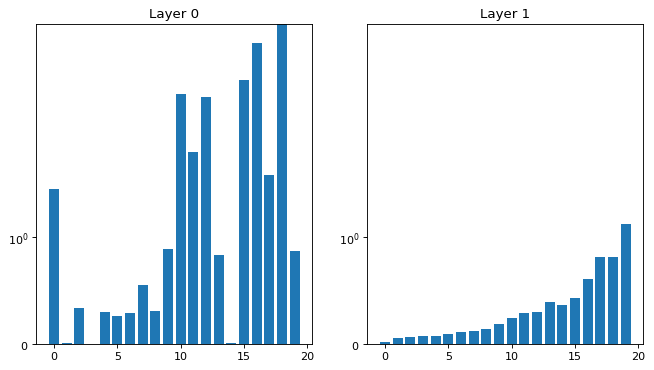

0.65253919142


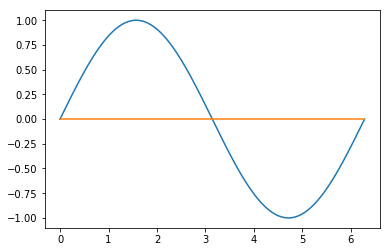

In [20]:
from sklearn.metrics import mean_absolute_error

network8 = Network(loss=MSE(), optimizer=GD(learning_rate=0.05), metrics=[mean_absolute_error])
network8.add(Dense(1,81,plot=True))
network8.add(Dense(81,1,plot=True))
network8.add(ReLU())
network8.fit(adata_x_train,adata_y_train, epochs= 10, print_stats=True)
print mean_absolute_error(network8.predict(adata_x_test), adata_y_test)

plt.plot(adata_x, adata_y)
plt.plot(adata_x, network8.predict(adata_x))